# **Deep Matrix Factorization with Spectral Geometric Regularization**
Submission at ICML 2020.

The following notebook elucidates the spectral geometric matrix completion (SGMC) method proposed in our paper. All the experimental findings shown in Section 4 of the paper can be reproduced using this notebook by changing various settings.


In [1]:
import numpy as np
import matplotlib
import os
import tensorflow as tf
#import numpy as np
import random
random.seed(0)
np.random.seed(0) #fix seed so we can reproduce the results
import h5py
import scipy
import scipy.io as sio
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
from scipy import linalg as linalg
import matplotlib.pyplot as plt
import networkx as nx
from numpy import linalg as npla
import IPython 

Defineing some util functions

In [0]:
# some util functions

def load_matlab_file(path_file, name_field):
    """
    load '.mat' files
    inputs:
        path_file, string containing the file path
        name_field, string containig the field name (default='shape')
    warning:
        '.mat' files should be saved in the '-v7.3' format
    """
    db = h5py.File(path_file, 'r')
    ds = db[name_field]
    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir = np.asarray(ds['ir'])
            jc = np.asarray(ds['jc'])
            out = sp.csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        # Transpose in case is a dense matrix because of the row- vs column- major ordering between python and matlab
        out = np.asarray(ds).astype(np.float32).T
    db.close()
    return out

def eigen(A):
    eigenValues, eigenVectors = npla.eigh(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return (eigenValues, eigenVectors)


def init_graph_basis(W):
    # gets basis returns eig_vals and eig_vecs
    W = W - np.diag(np.diag(W))
    D = np.diagflat(np.sum(W, 1))
    L = D - W
    eig_vals, eig_vecs = eigen(L)
    return eig_vals, eig_vecs

def squared_frobenius_norm(tensor):
    square_tensor = tf.square(tensor)
    tensor_sum = tf.reduce_sum(square_tensor)
    return tensor_sum

We load graphs $G_{r},G_{c}$ and visualize them. We use the graphs from the synthetic Netflix dataset (Monti et al. 2017) which have a community structure, but we can also use different graphs (commented block). 

We compute the Laplacian matrices $$\mathbf{L}_{r}=\mathbf{D}_{r}-\mathbf{W}_{r},$$$$\mathbf{L}_{c}=\mathbf{D}_{c}-\mathbf{W}_{c},$$ where $\mathbf{W}$ is the adjacency matrix and $\mathbf{D}=\mathrm{diag}(\mathbf{W}\mathbf{1})$ is the degree matrix, and compute their spectral decompositions, $$\mathbf{L}_{r} =\mathbf{\Phi}\mathbf{\Lambda}_{r}\mathbf{\Phi}^\top, $$ $$\mathbf{L}_{c} =\mathbf{\Psi}\mathbf{\Lambda}_{c}\mathbf{\Psi}^\top.$$

Text(0.5, 1.0, 'G_cols')

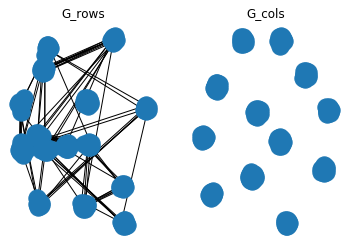

In [3]:
#load graphs and compute eigendecomposition of Laplacians

path_dataset = 'synthetic_netflix.mat'
# If the file is missing you can download it from here:
# https://drive.google.com/open?id=1eSvoc9e-vipiN4026ZgvZulidY-pN8U2
# and upload it into the Files folder on the left

"""
# load other kinds of graphs
m = 100
n = 100
row_graph = nx.path_graph(m)
col_graph = nx.path_graph(n)
W_rows = nx.adjacency_matrix(row_graph).toarray()
W_cols = nx.adjacency_matrix(col_graph).toarray()
"""


W_rows = load_matlab_file(path_dataset, 'Wrow').todense()  # Row Graph
W_cols = load_matlab_file(path_dataset, 'Wcol').todense()  # Column Graph
m = W_rows.shape[0]
n = W_cols.shape[0]

G_rows = nx.from_numpy_array(W_rows)
G_cols = nx.from_numpy_matrix(W_cols)

# extract Laplacians of the row and column graphs
eig_vals_row, eig_vecs_row = init_graph_basis(W_rows)
eig_vals_col, eig_vecs_col = init_graph_basis(W_cols)

eig_vals_row = np.expand_dims(eig_vals_row,1)
eig_vals_col = np.expand_dims(eig_vals_col,1)

# plot graphs
plt.subplot(1, 2, 1)
nx.draw(G_rows)
plt.title('G_rows')

plt.subplot(1, 2, 2)
nx.draw(G_cols)
plt.title('G_cols')

The rating matrix $\mathbf{M}$ is generated as follows: We generate the first $k_1\times k_2$ elements of the functional map
$\mathbf{C}$ by randomly sampling them from a Gaussian distribution with $\mu=0,\sigma=1$. The rest of the elements in $\mathbf{C}$ are set to zero.
$\mathbf{M}$ is given by $\mathbf{M}=\mathbf{\Phi}\mathbf{C}\mathbf{\Psi}^\top$.
 
This creates a rating matrix of rank $\min(k_1,k_1)$ which is also a bandlimited signal on the product graph $G_{r}\otimes G_{c}$.


Text(0.5, 1.0, 'M')

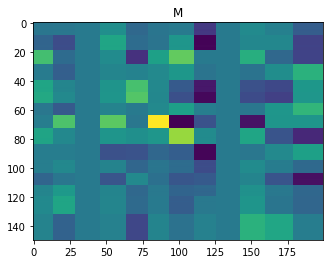

In [4]:
# generate bandlimited signal on product of two graphs

# set the bandlimits (this is also the rank)
k1 = 10
k2 = 10

C = np.random.randn(k1,k2)
M = np.matmul(np.matmul(eig_vecs_row[:,0:k1],C),np.transpose(eig_vecs_col[:,0:k2]))

# plot the generated rating matrix and the training set
plt.imshow(M)
plt.title('M')

Here we generate a random training set, encoded by $\mathbf{S}_{training}$. The test set will contain the rest of the matrix. 

The number of samples is important! We observe that in the data rich regime, DMF can recover the low-rank matrix without the graphs. But in the data poor regime, a more common setting in real world data sets, our method SGMC significantly outperforms DMF by exploiting the additional information encoded in the graphs.

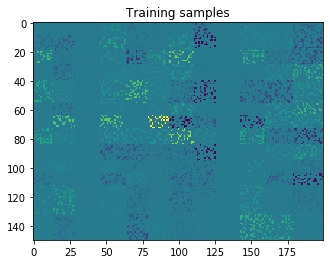

In [5]:
# generate training and test set
training_ratio = 0.20 #control the ratio of training samples
test_ratio = 1-training_ratio
S = np.random.rand(m,n)
S_training = (S<training_ratio)
S_test = (S>=(1-test_ratio))
M_training = np.multiply(M,S_training)
M_test = np.multiply(M,S_test)

plt.imshow(M_training)
plt.title('Training samples')
plt.show()


Here we set the hyperparameters for SGMC. Within this notebook we consider the overparametrized scenario $p_{max}=m,q_{max}=n$, to create a fair comparison between Deep Matrix Factorization (DMF) and SGMC. The rest of the hyperparameters were handtuned.


In [0]:
# hyperparams for SGMC
mu_r = 0.01
mu_c = 0.01
rho_r = 0.00
rho_c = 0.00

lr = 0.005 #learning rate
num_iters = 800000

alpha = 2 #scaling for the initialization, i.e., P,Q=(10^-alpha)*I

p_init = 1
q_init = 1
p_max = m
q_max = n

In this cell we set the experimental setting:

`perturb_flag` : This flag chooses whether to perturb the graphs used in SGMC. The perturbation adds (symmetric) noise to the adjacency matrix, controlled by `noise_level`. In order to make sure we don't get negative edges, we truncate the negative values.

`DMF` : This flag chooses whether to use the DMF method (`True`) or the SGMC method (`False`). If set to True, it will set $\alpha$ such that our initialization of $\mathbf{P},\mathbf{C},\mathbf{Q}$ will be scaled by $10^{-\alpha}$ $(\alpha>0)$ as suggested by Li et al. 2017 and pointed to us by reviewer #3.

Here we can also choose which parameters to optimize on from $\mathbf{P},\mathbf{C},\mathbf{Q}$. If we optimize just on $\mathbf{C}$ then we get the matrix completion counterpart of the *Functional Maps* (FM) method (Ovsjanikov et al. 2012).

In [0]:
#define flags
perturb_flag = False
DMF = False
zoomout_flag = False

# set flags for trainable parameters
train_P_flag = True
train_Q_flag = True
train_C_flag = True
train_lambda_row_flag = False
train_lambda_col_flag = False



if perturb_flag:
    # perturb graphs and use the perturbed graphs for Phi, Psi

    noise_level = 0.15

    # Perturb graphs
    row_noise = np.random.uniform(low=-noise_level, high=noise_level, size=[m, m])
    row_noise = 0.5 * (row_noise + np.transpose(row_noise))
    W_rows_perturbed = np.maximum(W_rows + row_noise, 0)

    col_noise = np.random.uniform(low=-noise_level, high=noise_level, size=[n, n])
    col_noise = 0.5 * (col_noise + np.transpose(col_noise))
    W_cols_perturbed = np.maximum(W_cols + col_noise, 0)


    #visualize perturbed graphs

    G_rows_perturbed = nx.from_numpy_array(W_rows_perturbed)
    G_cols_perturbed = nx.from_numpy_matrix(W_cols_perturbed)

    # plot graphs
    plt.subplot(1, 3, 1)
    nx.draw(G_rows_perturbed)
    plt.title('G_rows_perturbed')

    plt.subplot(1, 3, 2)
    nx.draw(G_cols_perturbed)
    plt.title('G_cols_perturbed')

    eig_vals_row, eig_vecs_row = init_graph_basis(W_rows_perturbed)
    eig_vals_col, eig_vecs_col = init_graph_basis(W_cols_perturbed)

    eig_vals_row = np.expand_dims(eig_vals_row,1)
    eig_vals_col = np.expand_dims(eig_vals_col,1)

    eig_vals_row_orig, eig_vecs_row_orig = init_graph_basis(W_rows)

    plt.subplot(1, 3, 3)
    plt.plot(eig_vals_row, 'r')
    plt.plot(eig_vals_row_orig, 'g')
    plt.show()

if DMF:
    # for Deep Matrix Factorization, use Identity basis

    eig_vals_row, eig_vecs_row = np.ones(m, dtype=np.float32), np.eye(m,dtype=np.float32)
    eig_vals_col, eig_vecs_col = np.ones(n, dtype=np.float32), np.eye(n,dtype=np.float32)

    eig_vals_row = np.expand_dims(eig_vals_row,1)
    eig_vals_col = np.expand_dims(eig_vals_col,1) 
    alpha = 2   # In DMF the initialization should be close to zero, so we use 10^{-2}

    #for DMF all flags should be true
    train_P_flag = True
    train_Q_flag = True
    train_C_flag = True
    train_lambda_row_flag = False
    train_lambda_col_flag = False

In this cell we define the computational graph in Tensorflow for the SGMC model. 

We initalize $\mathbf{C}$ by projecting $\mathbf{M}\odot \mathbf{S}_{training}$ on the first $p_{init},q_{init}$ vectors of $\mathbf{\Phi},\mathbf{\Psi}$. We usually use $p_{init}=1,q_{init}=1$. $\mathbf{P},\mathbf{Q}$ are initialized with identity. All variables are scaled by $10^{-\alpha}$.

We define the reconstructed signal $\mathbf{X}=\mathbf{\Phi}\mathbf{P}\mathbf{C}\mathbf{Q}^\top\mathbf{\Psi}^\top$.

In this notebook we focused only on the SGMC version of the loss described in the paper and not the complete zoomout loss. We also omit he orthogonalization energy which seems to have a negligible effect.

We minimize the following loss function:

\begin{equation}
    \min_{\mathbf{C},\mathbf{P},\mathbf{Q}}  E_{data} +
    \mu_{r}E_{dir}^r +\mu_{r}E_{dir}^c +\rho_r E_{diag}^r+\rho_c E_{diag}^c
\end{equation}

where 

\begin{aligned}
E_{data}&\equiv\left\|\left(\mathbf{X}-\mathbf{M}\right)\odot \mathbf{S}_{training}\right\|_F^2\\
E_{dir}^r&\equiv\mathrm{tr}\left(\mathbf{Q}\mathbf{C}^\top\mathbf{P}^\top\mathbf{\Lambda}_{r}\mathbf{P}\mathbf{C}\mathbf{Q}^\top\right),\\ 
E_{dir}^c&\equiv\mathrm{tr}\left(\mathbf{P}\mathbf{C}\mathbf{Q}^\top\mathbf{\Lambda}_{c}\mathbf{Q}\mathbf{C}^\top\mathbf{P}^\top\right),\\
E_{diag}^r&\equiv\left\|\mathrm{off} \left(\mathbf{P}^\top\mathbf{\Lambda}_r\mathbf{P}\right)\right\|_F^2,\\
E_{diag}^c&\equiv\left\|\mathrm{off} \left(\mathbf{Q}^\top\mathbf{\Lambda}_c\mathbf{Q}\right)\right\|_F^2.
\end{aligned}

For **DMF**, we set $\mu_r=\mu_c=\rho_r=\rho_c=0$, and $\mathbf{\Phi}=\mathbf{I},\mathbf{\Psi}=\mathbf{I}$.











In [0]:
# initialize C,P,Q
C_init = (10**(-alpha))*np.eye(p_max, q_max)
P_init = (10**(-alpha))*np.eye(m, p_max)
Q_init = (10**(-alpha))*np.eye(n, q_max)

C_tf = tf.Variable(C_init, trainable=train_C_flag, dtype=tf.float32)
P_tf = tf.Variable(P_init, trainable=train_P_flag, dtype=tf.float32)
Q_tf = tf.Variable(Q_init, trainable=train_Q_flag, dtype=tf.float32)

Phi_tf = tf.constant(eig_vecs_row, dtype=tf.float32)
Psi_tf = tf.constant(eig_vecs_col, dtype=tf.float32)

lambda_row_tf = tf.Variable(eig_vals_row, trainable=train_lambda_row_flag,
                            dtype=tf.float32)
lambda_col_tf = tf.Variable(eig_vals_col, trainable=train_lambda_col_flag, 
                            dtype=tf.float32)

S_training_tf = tf.constant(S_training, dtype=tf.float32)
S_test_tf = tf.constant(S_test, dtype=tf.float32)
M_training_tf = tf.constant(M_training, dtype=tf.float32)
M_test_tf = tf.constant(M_test, dtype=tf.float32)

C_new = tf.matmul(tf.matmul(P_tf, C_tf), tf.transpose(Q_tf))
X = tf.matmul(tf.matmul(Phi_tf, C_new), tf.transpose(Psi_tf))
E_data = squared_frobenius_norm(tf.multiply(X, S_training_tf) - M_training)

# estimate singular values of X 
sing_vals, u_tf, v_tf = tf.svd(X, compute_uv=True, full_matrices=True)
nuclear_norm = tf.norm(sing_vals, ord=1)

# Dirichlet energy
C_new_t = tf.transpose(C_new)
E_dirichlet_rows = tf.reduce_sum(tf.matmul(tf.transpose(tf.nn.relu(lambda_row_tf[0:C_new.shape[0],:])), tf.multiply(C_new, C_new)))
E_dirichlet_cols = tf.reduce_sum(tf.matmul(tf.transpose(tf.nn.relu(lambda_col_tf[0:C_new_t.shape[0],:])), tf.multiply(C_new_t, C_new_t)))

# off diag energy
off_diag_mask_rows = tf.ones([p_max, p_max]) - tf.eye(p_max)
off_diag_mask_cols = tf.ones([q_max, q_max]) - tf.eye(q_max)

diagonalized_rows = tf.matmul(tf.matmul(tf.transpose(P_tf), tf.diag(tf.squeeze(tf.nn.relu(lambda_row_tf)))), P_tf)
diagonalized_cols = tf.matmul(tf.matmul(tf.transpose(Q_tf), tf.diag(tf.squeeze(tf.nn.relu(lambda_col_tf)))), Q_tf)

E_diag_rows = squared_frobenius_norm(tf.multiply(off_diag_mask_rows, diagonalized_rows))
E_diag_cols = squared_frobenius_norm(tf.multiply(off_diag_mask_cols, diagonalized_cols))


if DMF:
  E_tot = E_data
else:
  E_tot = E_data + mu_r*E_dirichlet_rows+mu_c*E_dirichlet_cols+rho_r*E_diag_rows+rho_c*E_diag_cols

# get gradients
dL_dX = tf.gradients(E_tot, X)
diag_X = tf.eye(M_training.shape[0], M_training.shape[1])
off_diag_X = tf.ones(M_training.shape) - diag_X
grad_uv = tf.abs(tf.matmul(tf.transpose(u_tf), tf.matmul(dL_dX[0], v_tf)))
diag_mean = tf.reduce_mean(tf.multiply(grad_uv, diag_X))
diag_std = tf.math.reduce_std(tf.multiply(grad_uv, diag_X))
off_diag_mean = tf.reduce_mean(tf.multiply(grad_uv, off_diag_X))
off_diag_std = tf.math.reduce_std(tf.multiply(grad_uv, off_diag_X))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(E_tot)

# Create a session for running ops on the Graph.
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

train_loss = tf.sqrt(squared_frobenius_norm(tf.multiply(X, S_training_tf) - M_training_tf) / tf.reduce_sum(S_training_tf))
test_loss = tf.sqrt(squared_frobenius_norm(tf.multiply(X, S_test_tf)- M_test_tf) / tf.reduce_sum(S_test_tf))

This is the optimization loop. It displays $\mathbf{X}$ throughout the iterations, and the training and test errors every 1000 gradient descent iterations.

SGMC: iter 41000, train loss: 0.0030713137, test loss: 0.004716441, best test: 0.004716441, E_tot 0.07082826, E_dir_rows: 0.66934466, E_dir_cols: 0.60465896


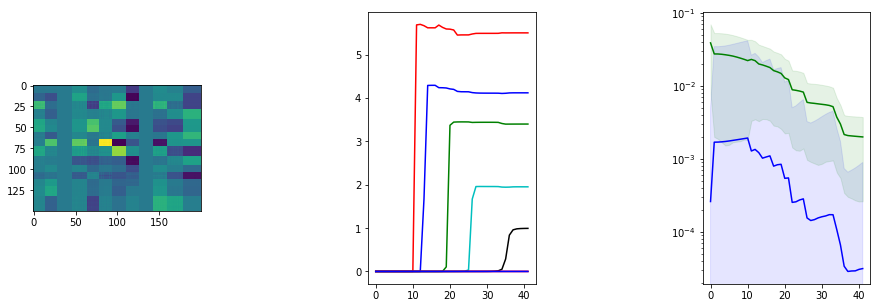

KeyboardInterrupt: ignored

In [9]:
 # optimize on E_tot
sing_vals_log = []
diag_means_log = []
off_diag_means_log = []
diag_stds_log=[]
off_diag_stds_log = []
method = 'SGMC'
if DMF:
  method = 'DMF'
log_freq = 1000
least_test_error=np.inf
for iter in range(num_iters):
    if iter%log_freq == 0:
      train_loss_np, test_loss_np, E_dirichlet_rows_np, E_dirichlet_cols_np,\
       E_tot_np, sing_val_np = sess.run([train_loss, 
                                          test_loss, 
                                          E_dirichlet_rows, 
                                          E_dirichlet_cols, 
                                          E_tot, 
                                          sing_vals])
      if test_loss_np < least_test_error:
        least_test_error = test_loss_np
      sing_vals_log.append(sing_val_np)
      IPython.display.clear_output()
      diag_mean_np, off_diag_mean_np, diag_std_np, off_diag_std_np \
      = sess.run([diag_mean, off_diag_mean, diag_std, off_diag_std])
      
      diag_means_log.append(diag_mean_np)
      off_diag_means_log.append(off_diag_mean_np)
      diag_stds_log.append(diag_std_np)
      off_diag_stds_log.append(off_diag_std_np)


      print(method + ": iter " + str(iter) +", train loss: "+str(train_loss_np)+", test loss: " + str(test_loss_np) + ", best test: " + str(least_test_error) +", E_tot " + str(E_tot_np) + ", E_dir_rows: " + str(E_dirichlet_rows_np) + ", E_dir_cols: " + str(E_dirichlet_cols_np))
      X_np = sess.run(X)
      
      # plot the reconstructed matrix
      fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
      fig.subplots_adjust(wspace=1)     
      ax1.imshow(X_np)

      # singular value evolution through convergence 
      ax2.plot(np.stack(sing_vals_log)[:,0], 'r', 
                   np.stack(sing_vals_log)[:,1], 'b',
                   np.stack(sing_vals_log)[:,3], 'g',
                   np.stack(sing_vals_log)[:,5], 'c',
                   np.stack(sing_vals_log)[:,7], 'k',
                   np.stack(sing_vals_log)[:,9], 'm',
                   np.stack(sing_vals_log)[:,10], 'r',
                   np.stack(sing_vals_log)[:,20], 'b',
                   )

      ax3.plot(diag_means_log, 'b',
               off_diag_means_log, 'g')
      ax3.fill_between(np.arange(0, (iter//log_freq)+1), 
                       np.stack(diag_means_log)-np.stack(diag_stds_log),
                       np.stack(diag_means_log)+np.stack(diag_stds_log),
                       alpha=0.1, color='b')
      ax3.fill_between(np.arange(0, (iter//log_freq)+1), 
                       np.stack(off_diag_means_log)-np.stack(off_diag_stds_log),
                       np.stack(off_diag_means_log)+np.stack(off_diag_stds_log),
                       alpha=0.1, color='g')
      ax3.set_yscale( "log" )
      plt.show()
    sess.run(opt_op)